In [34]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
# Show pipeline as plot
from sklearn import set_config
set_config(display='diagram')
import seaborn as sns

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,Unnamed: 0,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),...,Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy,age_group,age_category
0,0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy,40-50,adult
1,1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy,70-80,senior
2,2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy,70-80,senior
3,3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy,40-50,adult
4,4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy,60-70,senior


In [6]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [14]:
# random seed here deals with model initialization
rfc = RandomForestClassifier( oob_score=True )
logit = LogisticRegression( solver="saga" )
clf = Pipeline( steps=[('rfc', SelectFromModel(rfc)), ('logistic', logit)] )
param_grid = {'rfc__estimator__n_estimators': [50, 100],
                'rfc__estimator__max_depth': [50, 100]}
model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(metrics.balanced_accuracy_score), cv = 5)
MyTrainer = Trainer(model = model, scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [15]:
#y = SampleMeta['Phenotype'].to_numpy().astype('str')
y = SampleMeta['age_category'].to_numpy().astype('str')
#y = y.astype('int64')
y

array(['adult', 'senior', 'senior', ..., 'child', 'youth', 'youth'],
      dtype='<U7')

In [16]:
oneHotEncoders, oneHotMap = MyMultiTrainTester.buildEncoder( np.unique(y) )

In [17]:
oneHotMap

{'adult': 0, 'child': 1, 'senior': 2, 'unknown': 3, 'youth': 4}

In [18]:
y = np.array([ oneHotMap[class_pheno] for class_pheno in y ])
y

array([0, 2, 2, ..., 1, 4, 4])

In [19]:
MyMultiTrainTester.train(MatrixData, y)

Running for split 1 of 5
Running for split 2 of 5
Running for split 3 of 5
Running for split 4 of 5
Running for split 5 of 5


In [20]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.856913,train
1,0.862366,train
2,0.850587,train
3,0.832732,train
4,0.908001,train
0,0.320486,test
1,0.317796,test
2,0.268796,test
3,0.286971,test
4,0.317835,test


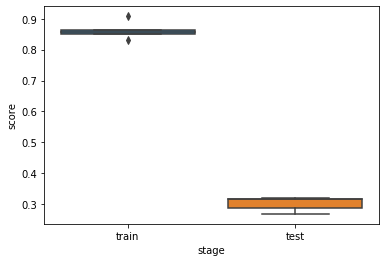

In [21]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

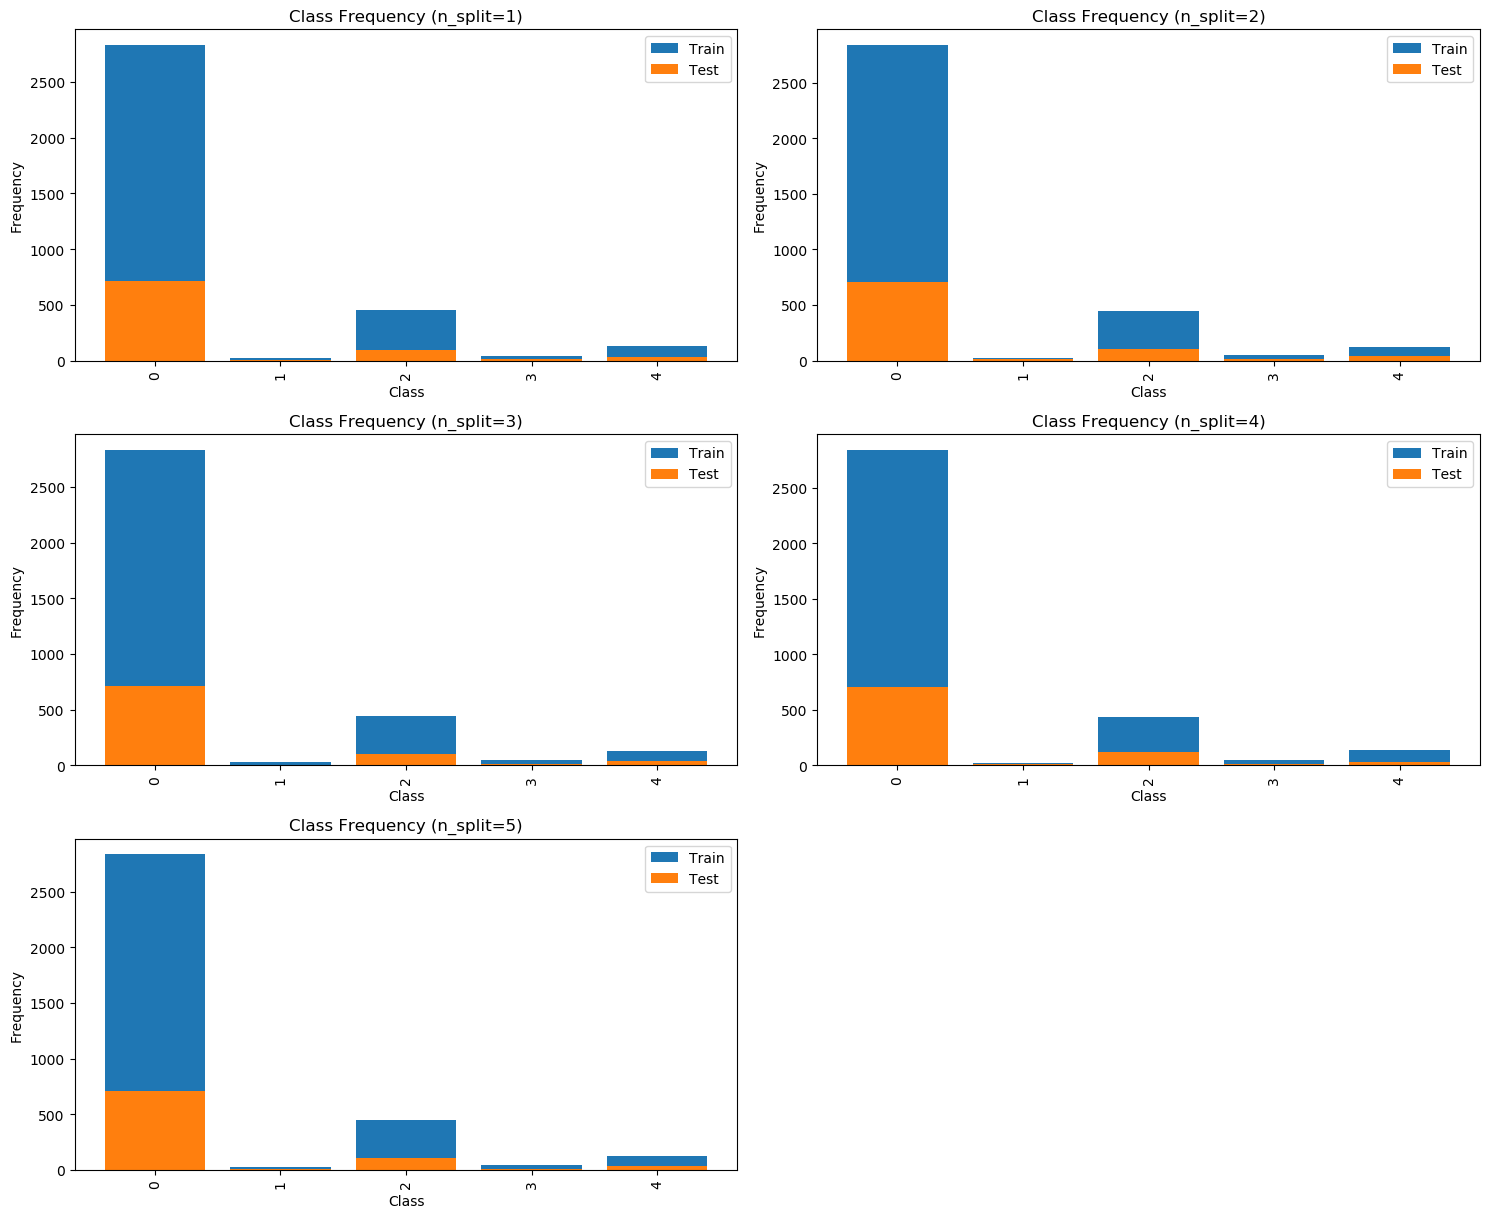

In [22]:
MyMultiTrainTester.plot_class_freq(normalize=True)

In [23]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [24]:
FinalModel.model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc',
                                        SelectFromModel(estimator=RandomForestClassifier(oob_score=True))),
                                       ('logistic',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'rfc__estimator__max_depth': [50, 100],
                         'rfc__estimator__n_estimators': [50, 100]},
             scoring=make_scorer(balanced_accuracy_score))

In [35]:
FinalModel.model.best_estimator_

Pipeline(steps=[('rfc',
                 SelectFromModel(estimator=RandomForestClassifier(max_depth=100,
                                                                  oob_score=True))),
                ('logistic', LogisticRegression(solver='saga'))])

# Distribution of RF Feature Importances

In [26]:
feat_importances = pd.DataFrame(FinalModel.model.best_estimator_.steps[0][1].estimator_.feature_importances_, index=FeatMeta.feature, columns=["Importance"])

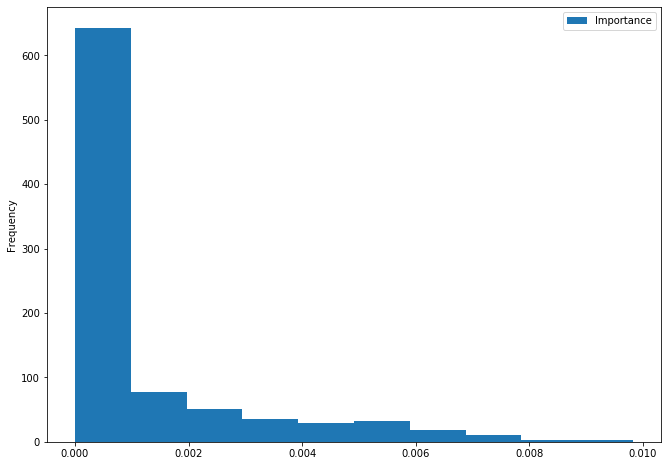

In [27]:
feat_importances.sort_values(["Importance"], ascending=False, inplace=False).plot(kind="hist", figsize=(11, 8))

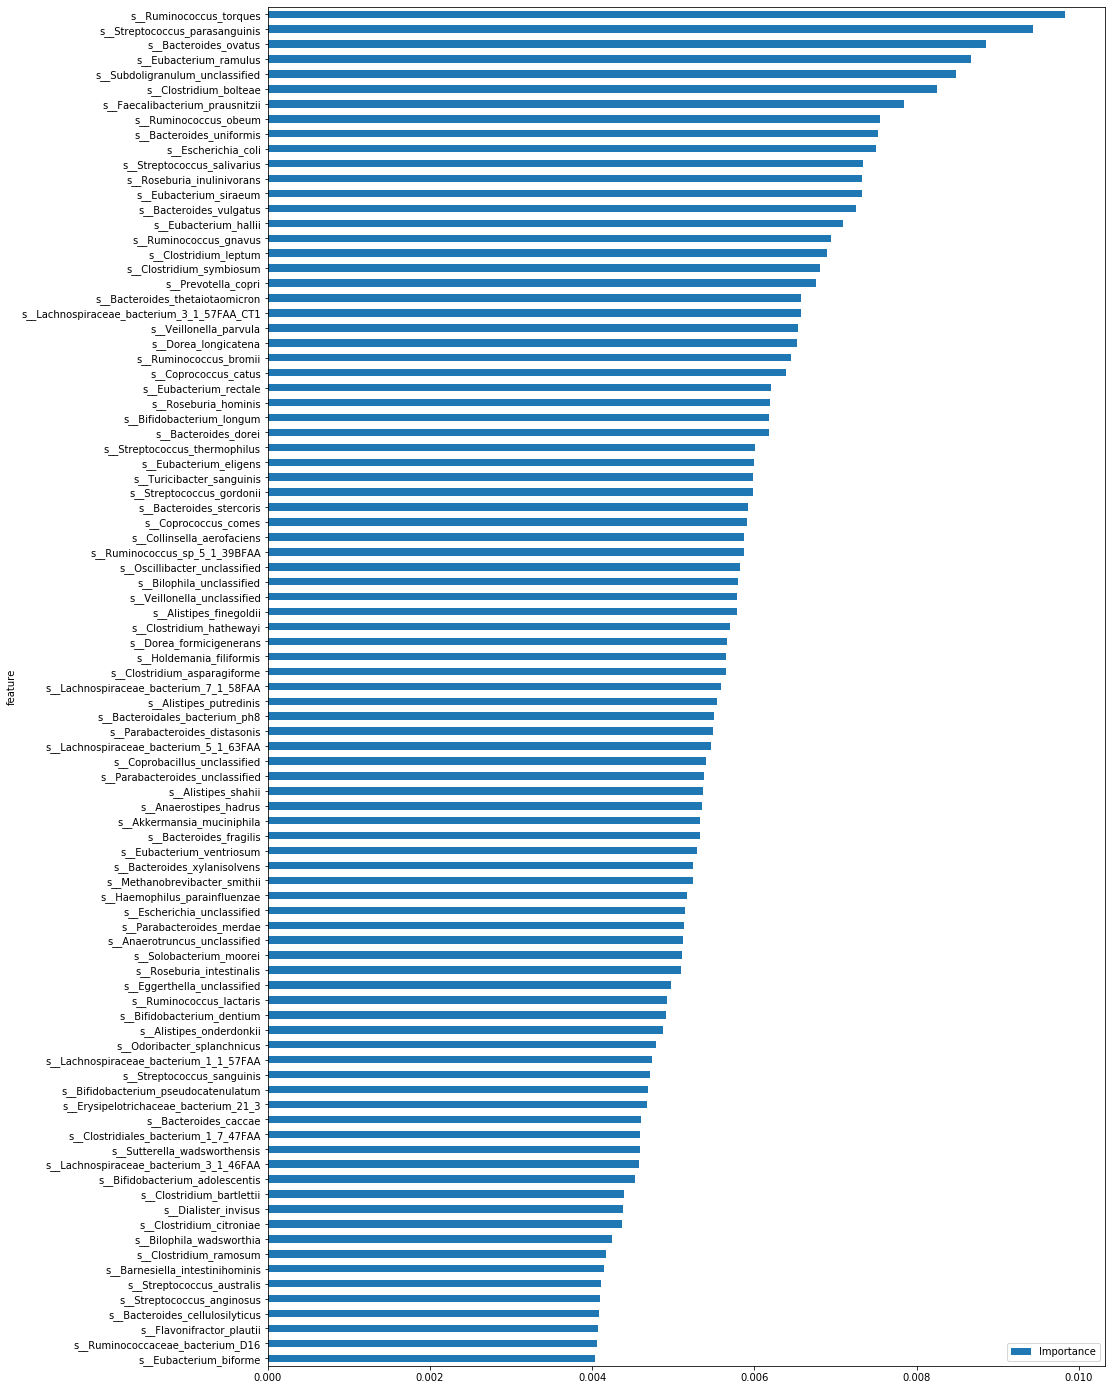

In [28]:
feat_importances[feat_importances>0.004].dropna().sort_values(["Importance"], ascending=True).plot(kind='barh', figsize=(15,25))

# Features Selected for Logistic Regression

There are 245 features that get selected and passed to the Logistic Regression

In [30]:
sum(FinalModel.model.best_estimator_.steps[0][1].get_support())

245

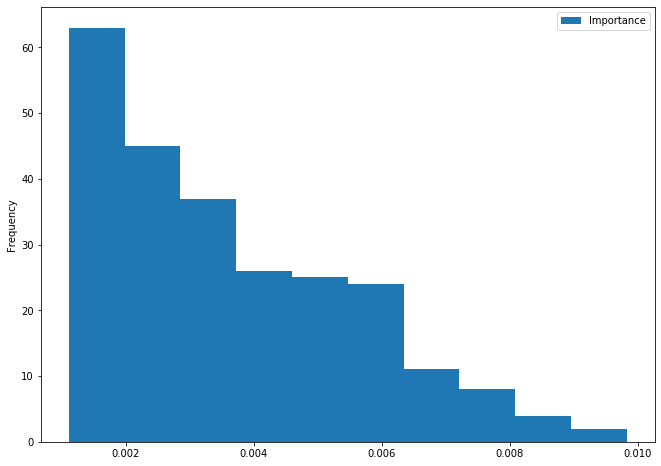

In [29]:
feat_importances[ FinalModel.model.best_estimator_.steps[0][1].get_support() ].sort_values(["Importance"], ascending=False, inplace=False).plot(kind="hist", figsize=(11, 8))

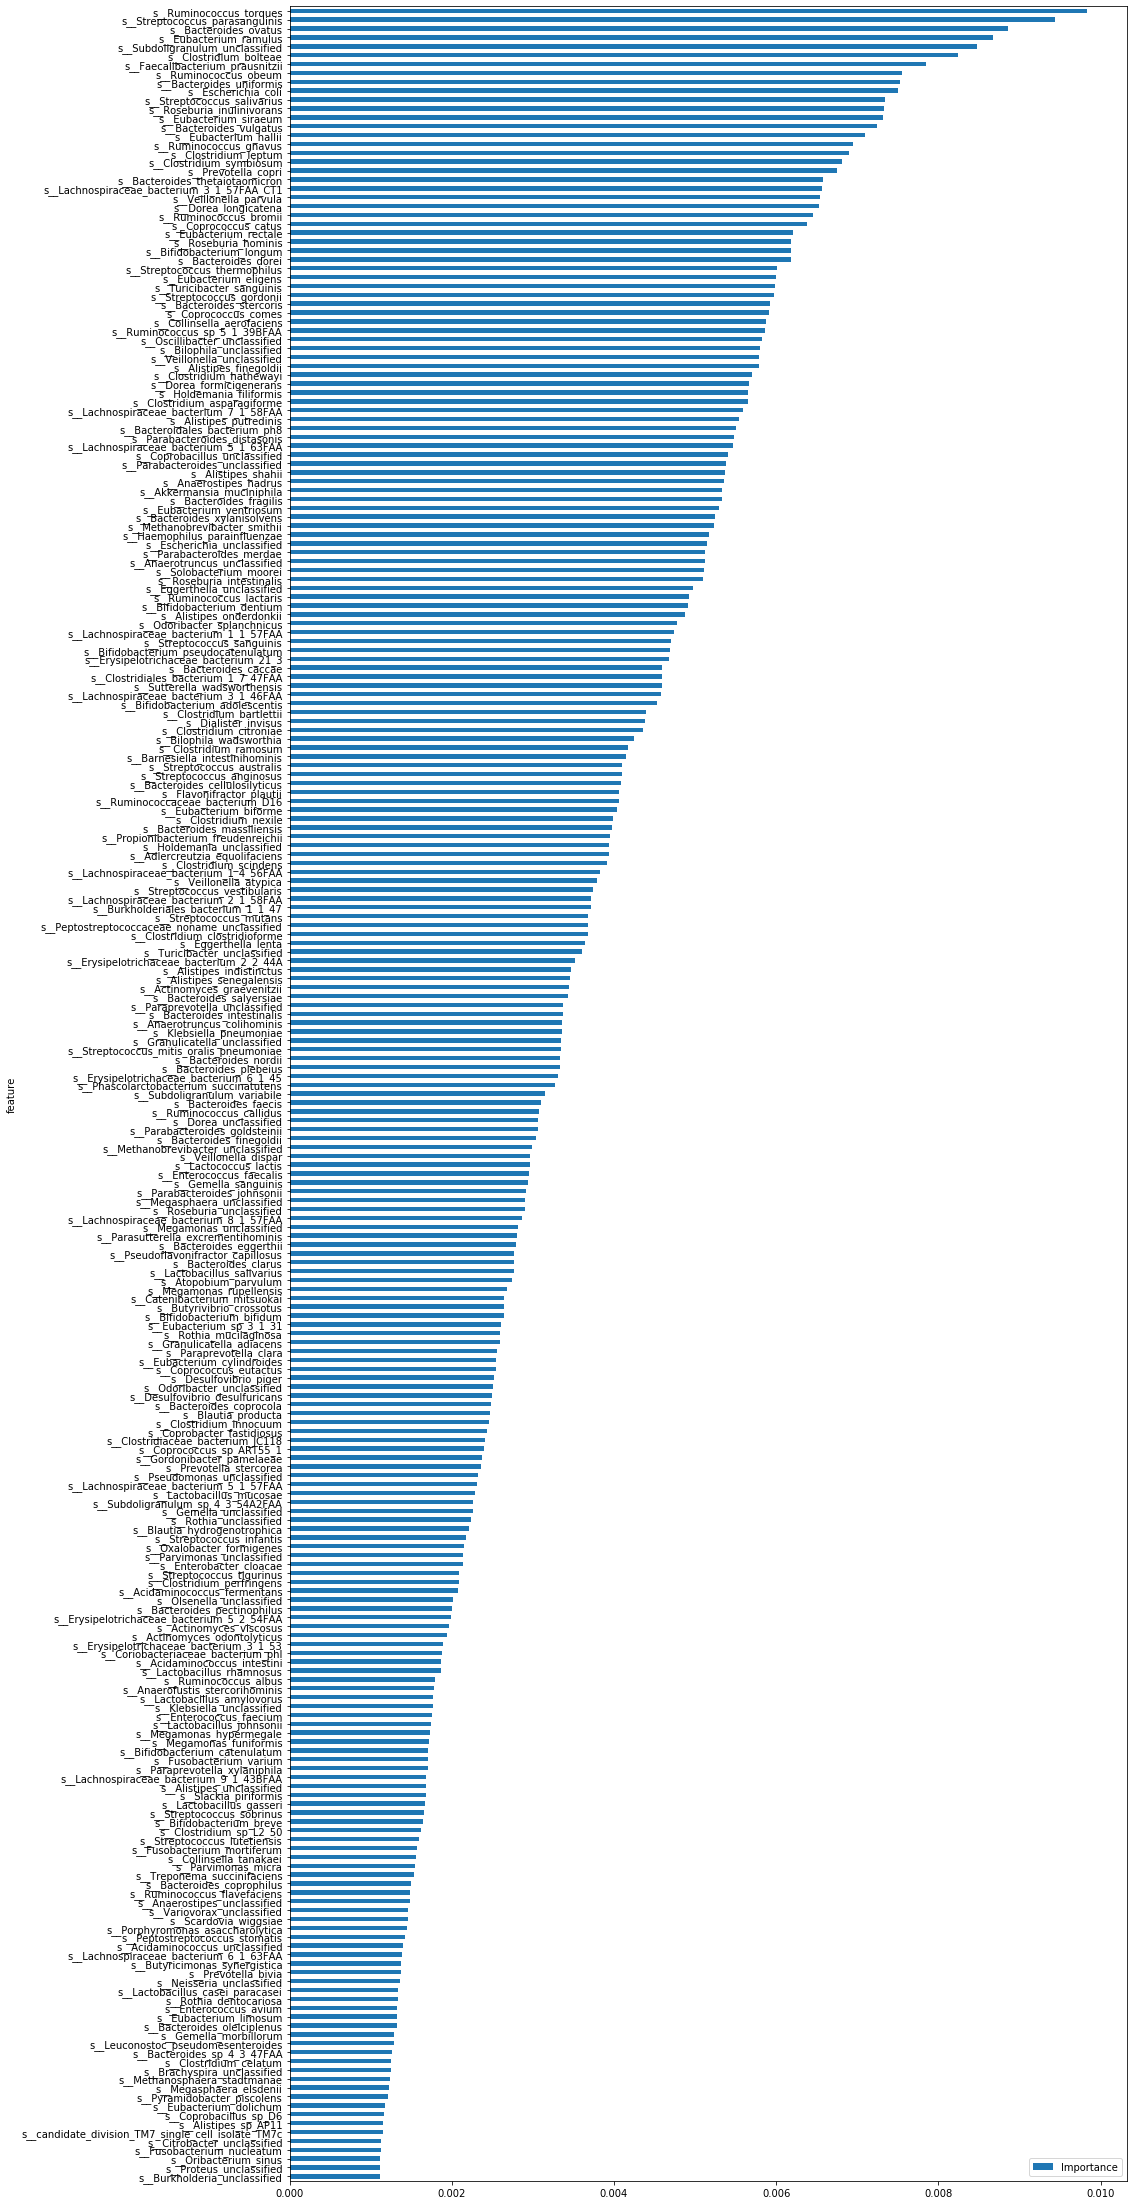

In [31]:
feat_importances[ FinalModel.model.best_estimator_.steps[0][1].get_support() ].dropna().sort_values(["Importance"], ascending=True).plot(kind='barh', figsize=(15,40))

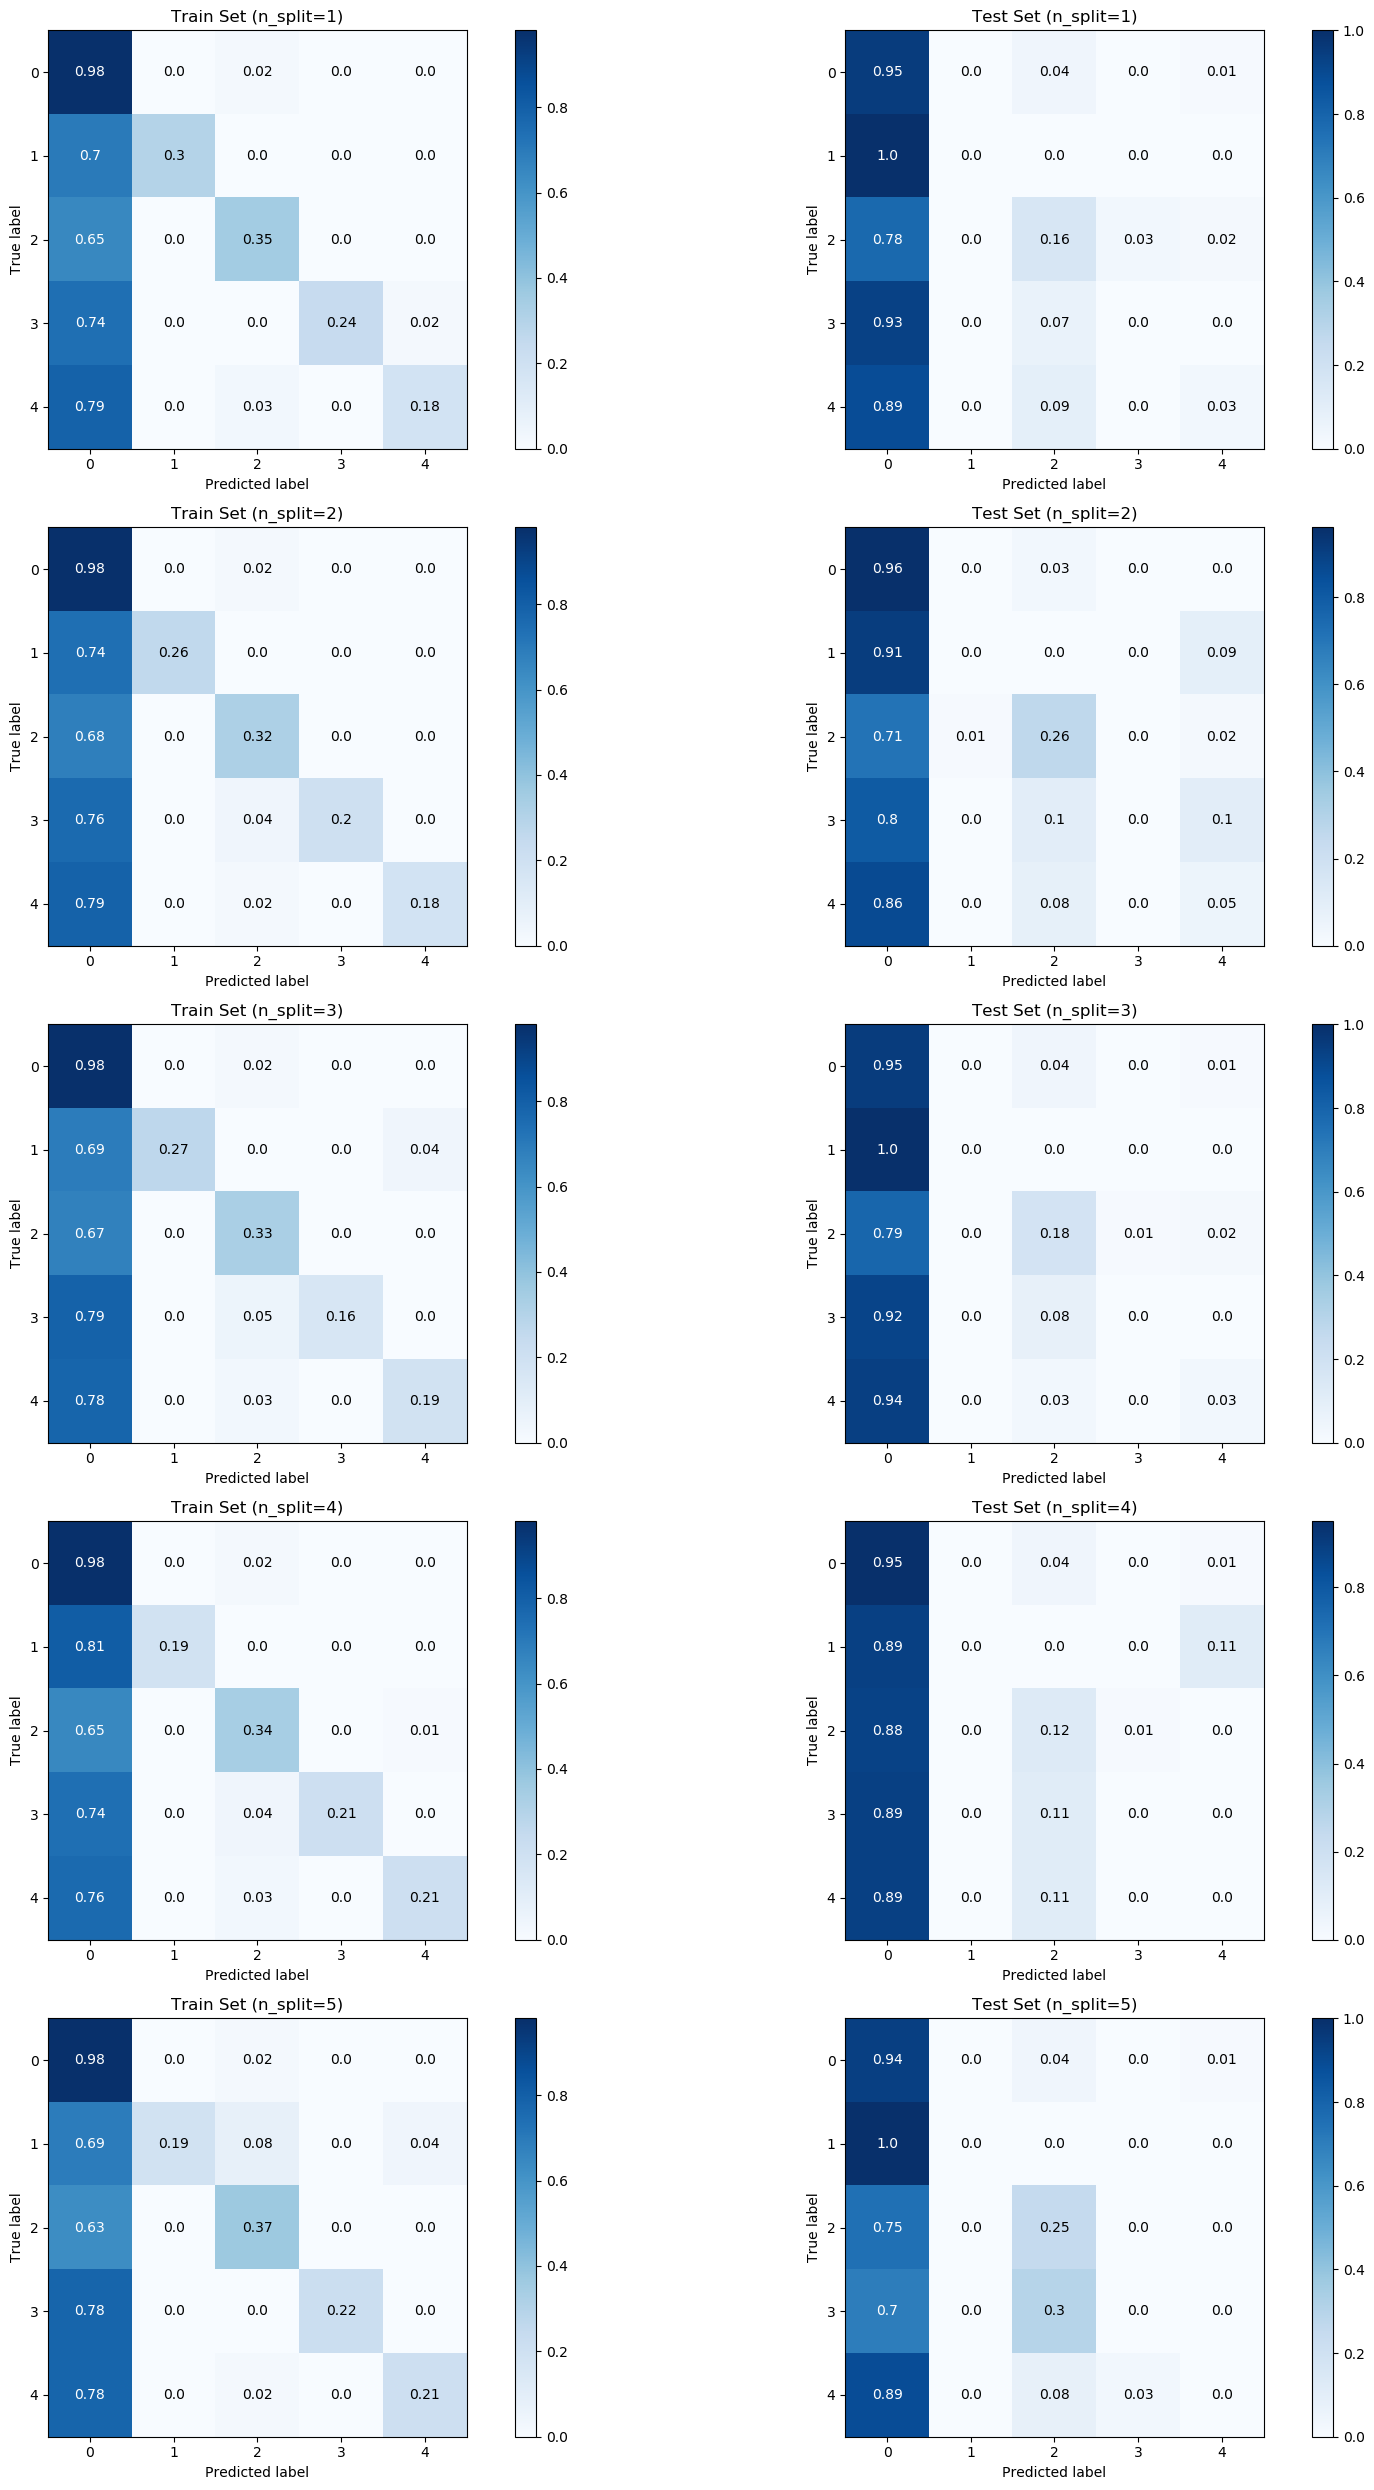

In [32]:
MyMultiTrainTester.plot_confusion(normalize=True)

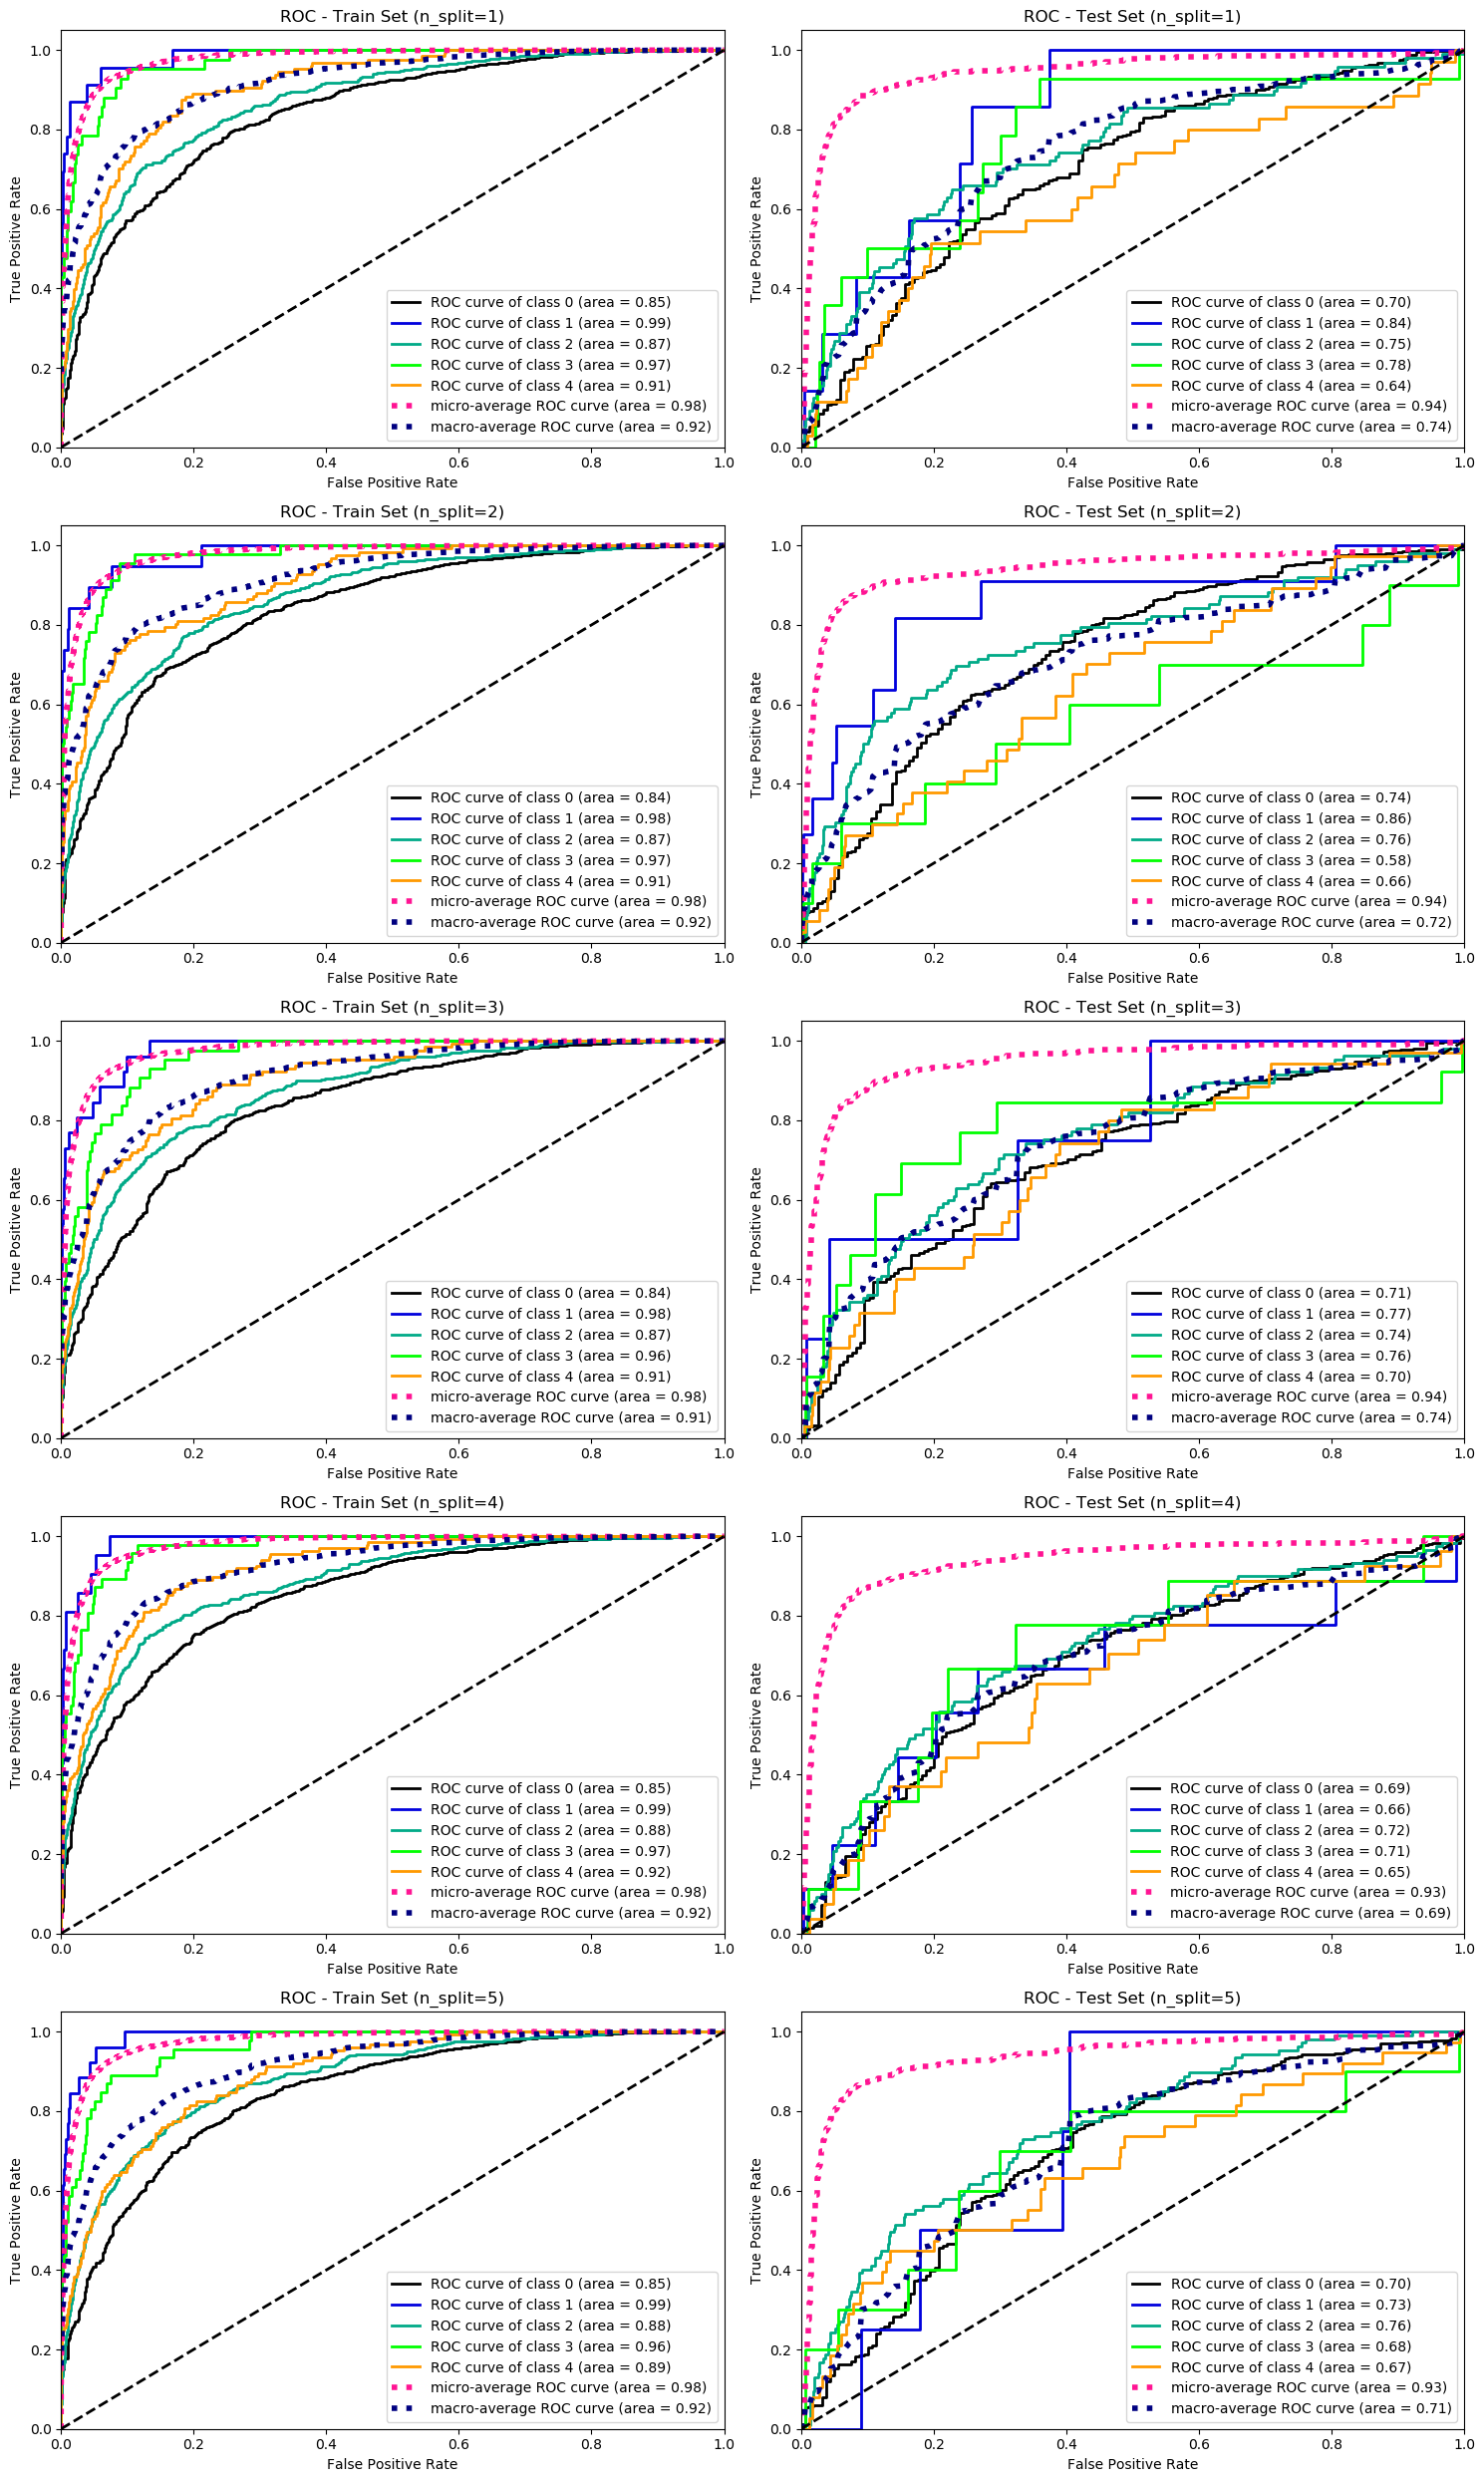

In [33]:
MyMultiTrainTester.plot_roc()